Imports

In [33]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import joblib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2


Data loading

In [34]:
train = pd.read_csv("data/train.csv")

features = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea']
target = 'SalePrice'

X = train[features].values
y = train[target].values


Normalize inputs and perform separation.

In [35]:
scaler = StandardScaler()
scaler_y = StandardScaler()

X_train, X_val, Y_train, Y_val = train_test_split(X, y, train_size=0.8, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


Y_train_scaled = scaler_y.fit_transform(Y_train.reshape(-1, 1))
Y_val_scaled = scaler_y.transform(Y_val.reshape(-1, 1))


Create the neural network and perform the compilation.

In [36]:
#model assembly
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),

    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation="relu"),
    Dense(1)
])
#Compilation
model.compile(optimizer=Adam(learning_rate=0.001),loss="mse")

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
#Training
history = model.fit(X_train_scaled,Y_train_scaled,validation_data=(X_val_scaled, Y_val_scaled),epochs=200,batch_size=32,callbacks=[early_stop])

#Predict
preds_scaled = model.predict(X_val_scaled)
preds = scaler_y.inverse_transform(preds_scaled)

Epoch 1/200


c:\Users\Bruno\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9939 - val_loss: 1.0282
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5502 - val_loss: 0.9706
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5967 - val_loss: 0.8912
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4351 - val_loss: 0.7822
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3861 - val_loss: 0.7005
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4172 - val_loss: 0.6244
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3611 - val_loss: 0.5512
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3567 - val_loss: 0.5008
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3594 - val_loss: 0.5353
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3299 - val_loss: 0.4555
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3151 - val_loss: 0.3935
Epoch 12/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3818 - val_lo

Save models

In [37]:
#Save model and scaler
path_backend = "../ImovelCalc_back/models/ml_models/"
model.save(path_backend+"house_price_model.h5")
np.save(path_backend+"scaler.npy", scaler.scale_)
np.save(path_backend+"scaler_mean.npy", scaler.mean_)
joblib.dump(scaler, path_backend+"scaler_X.pkl")
joblib.dump(scaler_y, path_backend+"scaler_y.pkl")
#Evaluate performance
rmse = np.sqrt(mean_squared_error(Y_val, preds))
print(f"RMSE no conjunto de validação: {rmse:.2f}")

RMSE no conjunto de validação: 31944.85


Validações

In [38]:
#NORMALIZED Predict
Y_val_pred_scaled = model.predict(X_val_scaled)

#denormalizes to real values ​​(price)
Y_val_pred = scaler_y.inverse_transform(Y_val_pred_scaled)
Y_val_real = Y_val.reshape(-1, 1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [39]:
rmse = np.sqrt(mean_squared_error(Y_val_real, Y_val_pred))
mae = mean_absolute_error(Y_val_real, Y_val_pred)
r2 = r2_score(Y_val_real, Y_val_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}")


RMSE: 31,944.85
MAE : 20,724.92
R²  : 0.8670


Gráficos

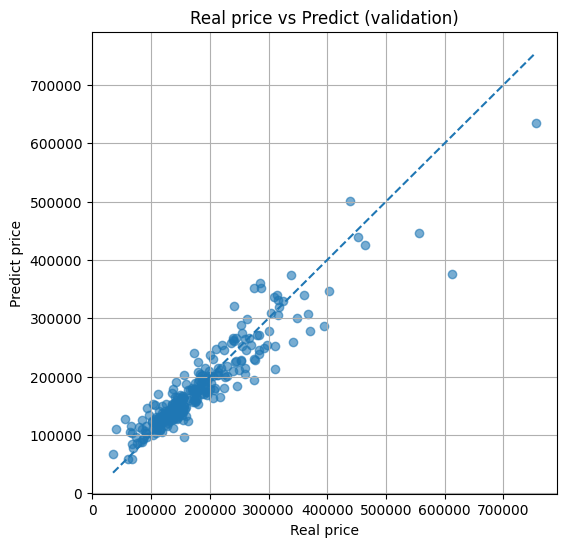

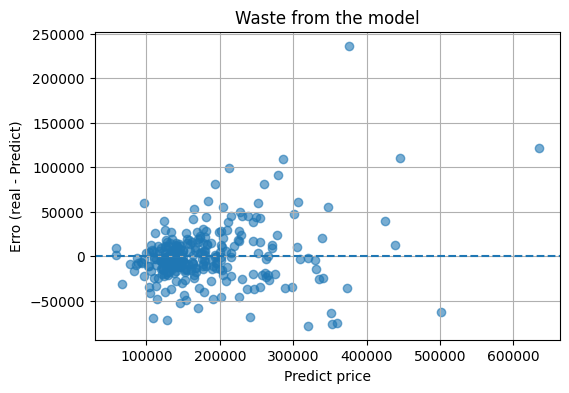

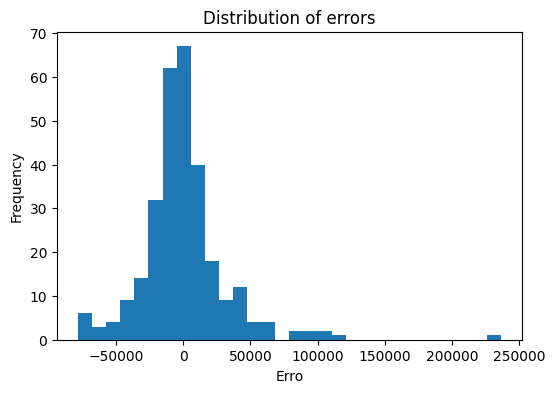

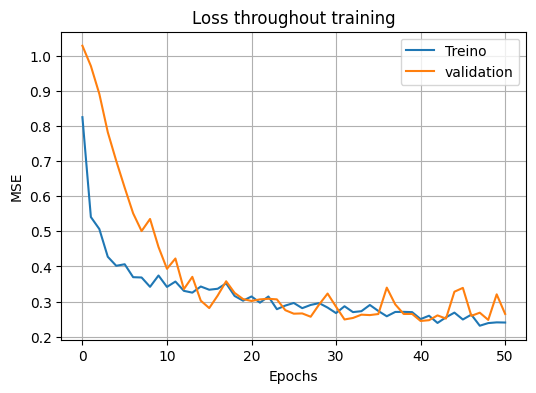

In [40]:
plt.figure(figsize=(6,6))
plt.scatter(Y_val_real, Y_val_pred, alpha=0.6)
plt.plot(
    [Y_val_real.min(), Y_val_real.max()],
    [Y_val_real.min(), Y_val_real.max()],
    linestyle="--"
)
plt.xlabel("Real price")
plt.ylabel("Predict price")
plt.title("Real price vs Predict (validation)")
plt.grid(True)
plt.show()

residuals = Y_val_real - Y_val_pred

plt.figure(figsize=(6,4))
plt.scatter(Y_val_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predict price")
plt.ylabel("Erro (real - Predict)")
plt.title("Waste from the model")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel("Erro")
plt.ylabel("Frequency")
plt.title("Distribution of errors")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Loss throughout training")
plt.legend()
plt.grid(True)
plt.show()
